Exercitiul 1

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
import random

In [3]:
dataset = np.loadtxt('ca-AstroPh.txt', dtype=int, comments='#', max_rows=1500)
print(dataset)

[[ 84424    276]
 [ 84424   1662]
 [ 84424   5089]
 ...
 [101811 129446]
 [101811 132760]
 [ 75665  13353]]


C:\Users\bucur\AppData\Local\Temp\ipykernel_8356\2366363427.py:1: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=1500`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  dataset = np.loadtxt('ca-AstroPh.txt', dtype=int, comments='#', max_rows=1500)


In [4]:
G = nx.Graph()
for edge in dataset:
    node1, node2 = edge
    if G.has_edge(node1, node2):
        G[node1][node2]['weight'] += 1
    else:
        G.add_edge(node1, node2, weight=1)

In [5]:
def compute_features(graph):
    features = {}
    nodes = list(graph.nodes())
    for node in nodes:
        egonet = nx.ego_graph(graph, node, radius=1)
        Ni = egonet.number_of_nodes()
        Ei = egonet.number_of_edges()
        Wi = sum(d['weight'] for _, _, d in egonet.edges(data=True))

        adjacency_matrix = nx.to_numpy_array(egonet, weight='weight')
        eigenvalues, _ = np.linalg.eigh(adjacency_matrix)
        principal_eigenval = max(eigenvalues)
        
        features[node] = {
            'Ni': Ni,
            'Ei': Ei,
            'Wi': Wi,
            'lambda_wi': principal_eigenval.real
        }
        
    nx.set_node_attributes(graph, features)
    
    return nodes

In [6]:
def get_Ni_Ei(graph, nodes):
    Ni = np.array([graph.nodes[node]['Ni'] for node in nodes])
    Ei = np.array([graph.nodes[node]['Ei'] for node in nodes])  
    
    return Ni, Ei

In [7]:
nodes = compute_features(G)
Ni, Ei = get_Ni_Ei(G, nodes)

In [8]:
def fit_linear_reg(Ni,Ei):
    log_Ni = np.log(Ni + 1)
    log_Ei = np.log(Ei + 1)

    X = log_Ni.reshape(-1, 1) 
    y = log_Ei 
    model = LinearRegression()
    model.fit(X, y)
    theta = model.coef_[0]
    log_C = model.intercept_
    C = np.exp(log_C)
    
    return theta, C

In [9]:
def calc_anomaly_scores(graph, nodes, Ni, Ei, theta, C):
    anomaly_scores = {}
    for node, ni, ei in zip(nodes, Ni, Ei):
        predicted_ei = C * (ni ** theta)
        score = (max(ei, predicted_ei) / min(ei, predicted_ei)) * np.log(abs(ei - predicted_ei) + 1)
        anomaly_scores[node] = score

    nx.set_node_attributes(graph, anomaly_scores, 'anomaly_score')
    
    return anomaly_scores

In [10]:
theta, C=fit_linear_reg(Ni,Ei)
anomaly_scores = calc_anomaly_scores(G, nodes, Ni, Ei, theta, C)

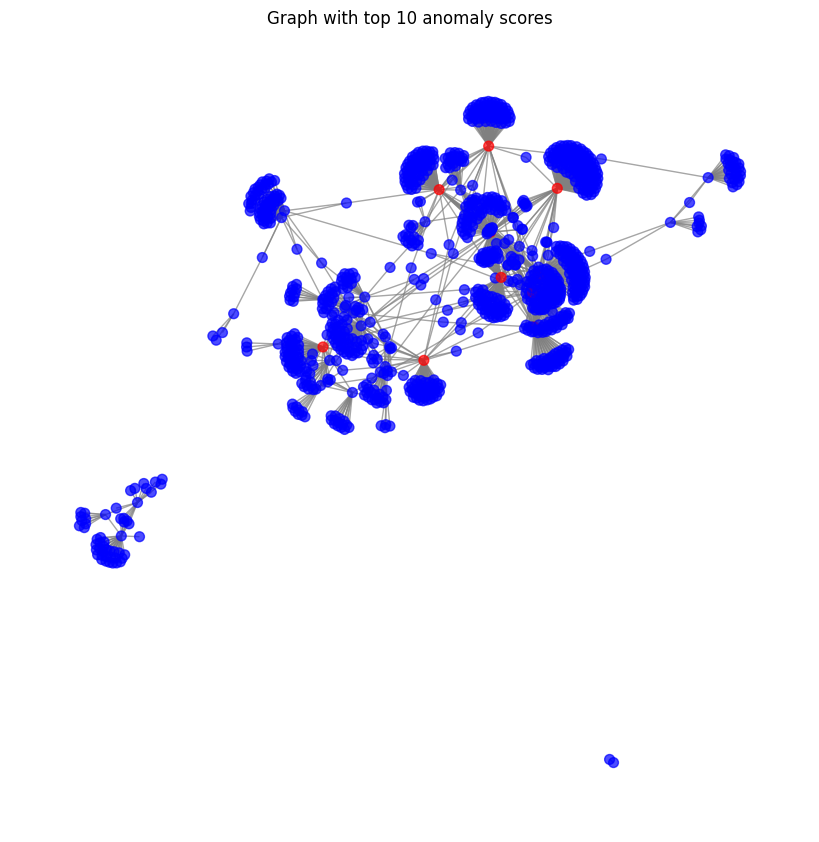

In [11]:
sorted_scores = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)
top_10_nodes = [node for node, _ in sorted_scores[:10]]

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)

node_colors = ['red' if node in top_10_nodes else 'blue' for node in G.nodes()]

nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=50, edge_color='gray', alpha=0.7)
plt.title("Graph with top 10 anomaly scores")
plt.show()

In [12]:
normalized_scores = []
for node, ni, ei in zip(nodes, Ni, Ei):
    predicted_ei = C * (ni ** theta)
    score = (max(ei, predicted_ei) / min(ei, predicted_ei)) * np.log(abs(ei - predicted_ei) + 1)
    normalized_scores.append(score)

normalized_scores = np.array(normalized_scores)

In [13]:
lof = LocalOutlierFactor(n_neighbors=20)
lof_scores = -lof.fit_predict(np.column_stack((Ei, Ni)))

final_anom_scores = normalized_scores + lof_scores

final_sorted_scores = sorted(zip(nodes, final_anom_scores), key=lambda x: x[1], reverse=True)
final_top_10_nodes = [node for node, _ in final_sorted_scores[:10]]

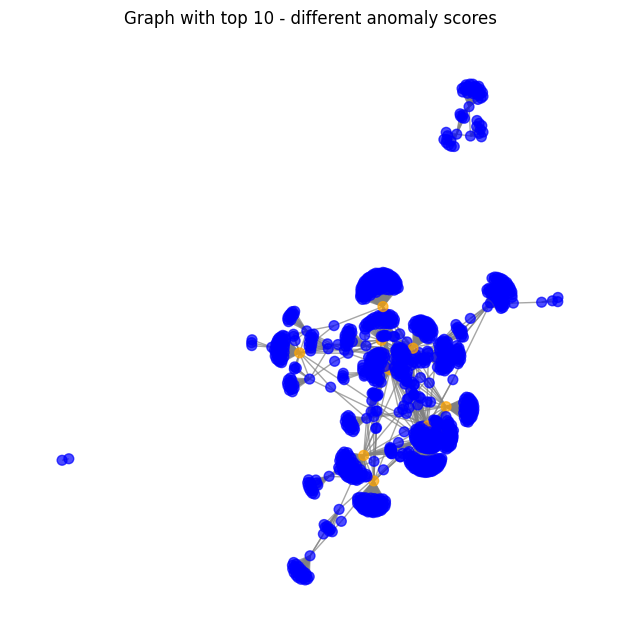

In [14]:
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G)

node_colors = ['orange' if node in top_10_nodes else 'blue' for node in G.nodes()]

nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=50, edge_color='gray', alpha=0.7)
plt.title("Graph with top 10 - different anomaly scores")
plt.show()

Exercitiul 2

In [15]:
regular_graph = nx.random_regular_graph(d=3, n=100)
other_graph = nx.connected_caveman_graph(10, 20)

merged_graph = nx.union(regular_graph, other_graph, rename=("regular_", "caveman_"))

nodes_regular = [n for n in merged_graph if "regular_" in n]
nodes_caveman = [n for n in merged_graph if "caveman_" in n]
for _ in range(10): 
    node_from_regular = random.choice(nodes_regular)
    node_from_caveman = random.choice(nodes_caveman)
    merged_graph.add_edge(node_from_regular, node_from_caveman)

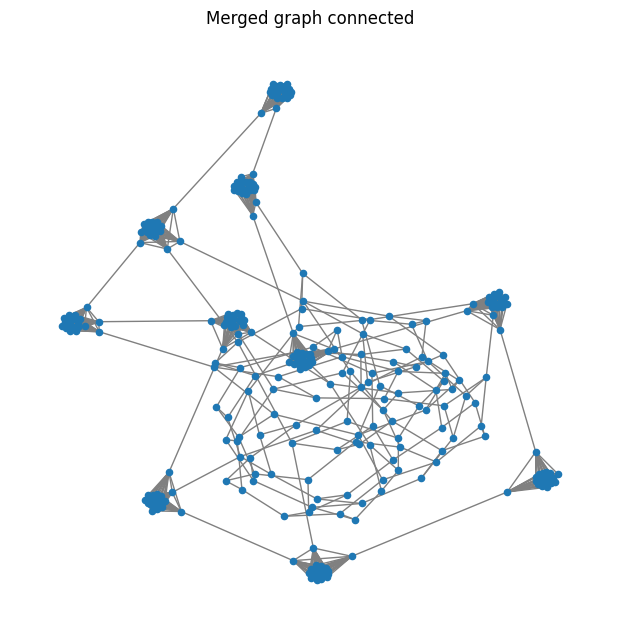

In [16]:
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(merged_graph)  
nx.draw(merged_graph, pos, node_size=20, edge_color="gray", with_labels=False)
plt.title("Merged graph connected")
plt.show()

In [17]:
features = {}
nodes = list(merged_graph.nodes())
for node in nodes:
    egonet = nx.ego_graph(merged_graph, node, radius=1)
    Ni = egonet.number_of_nodes()
    Ei = egonet.number_of_edges()
    
    adjacency_matrix = nx.to_numpy_array(egonet)
    eigenvalues, _ = np.linalg.eigh(adjacency_matrix)
    principal_eigenval = max(eigenvalues)
    
    features[node] = {
        'Ni': Ni,
        'Ei': Ei,
        'lambda': principal_eigenval.real,
    }

In [18]:
nx.set_node_attributes(merged_graph, features)
Ni, Ei = get_Ni_Ei(merged_graph, nodes)
theta, C=fit_linear_reg(Ni,Ei)
anomaly_scores = calc_anomaly_scores(merged_graph, nodes, Ni, Ei, theta, C)

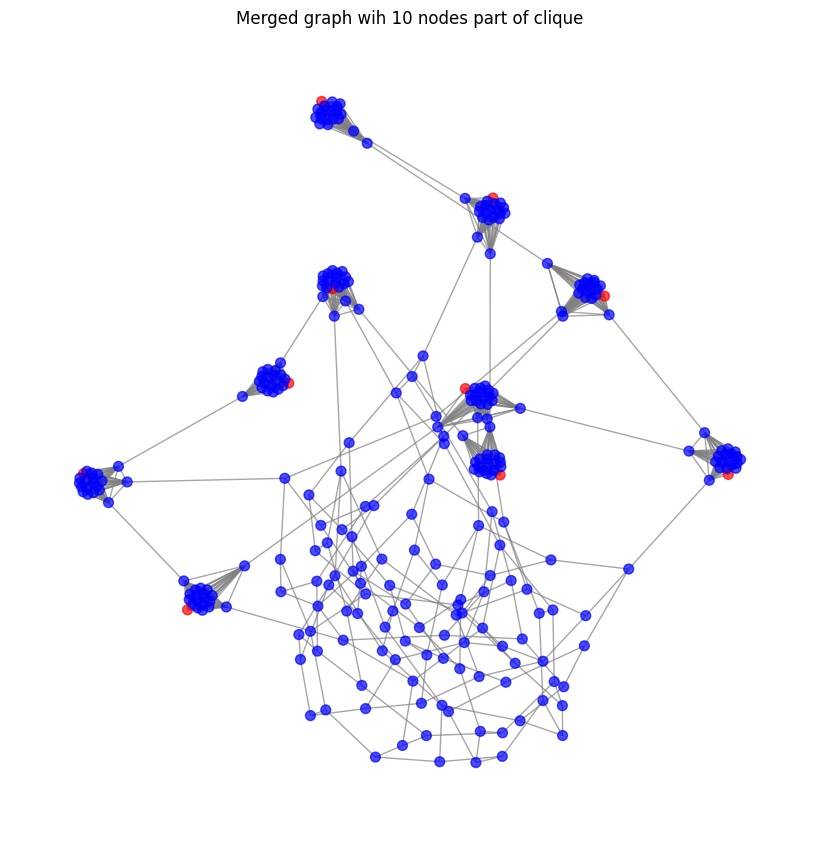

In [19]:
sorted_scores = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)
top_10_nodes = [node for node, _ in sorted_scores[:10]]

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(merged_graph)

node_colors = ['red' if node in top_10_nodes else 'blue' for node in merged_graph.nodes()]

nx.draw(merged_graph, pos, with_labels=False, node_color=node_colors, node_size=50, edge_color='gray', alpha=0.7)
plt.title("Merged graph wih 10 nodes part of clique")
plt.show()

In [27]:
graph1 = nx.random_regular_graph(d=3, n=100)
graph2 = nx.random_regular_graph(d=5, n=100)

merged_graph = nx.union(graph1, graph2, rename=("g1_", "g2_"))
for edge in merged_graph.edges():
    merged_graph.add_edge(edge[0], edge[1], weight=1)

In [28]:
two_random_nodes = random.sample(list(merged_graph.nodes()), 2)
for node in two_random_nodes:
    egonet = nx.ego_graph(merged_graph, node, radius=1)
    for edge in egonet.edges():
        merged_graph[edge[0]][edge[1]]["weight"] += 10

In [29]:
nodes = compute_features(merged_graph)
Ni, Ei = get_Ni_Ei(merged_graph, nodes)
theta, C=fit_linear_reg(Ni,Ei)
anomaly_scores = calc_anomaly_scores(merged_graph, nodes, Ni, Ei, theta, C)

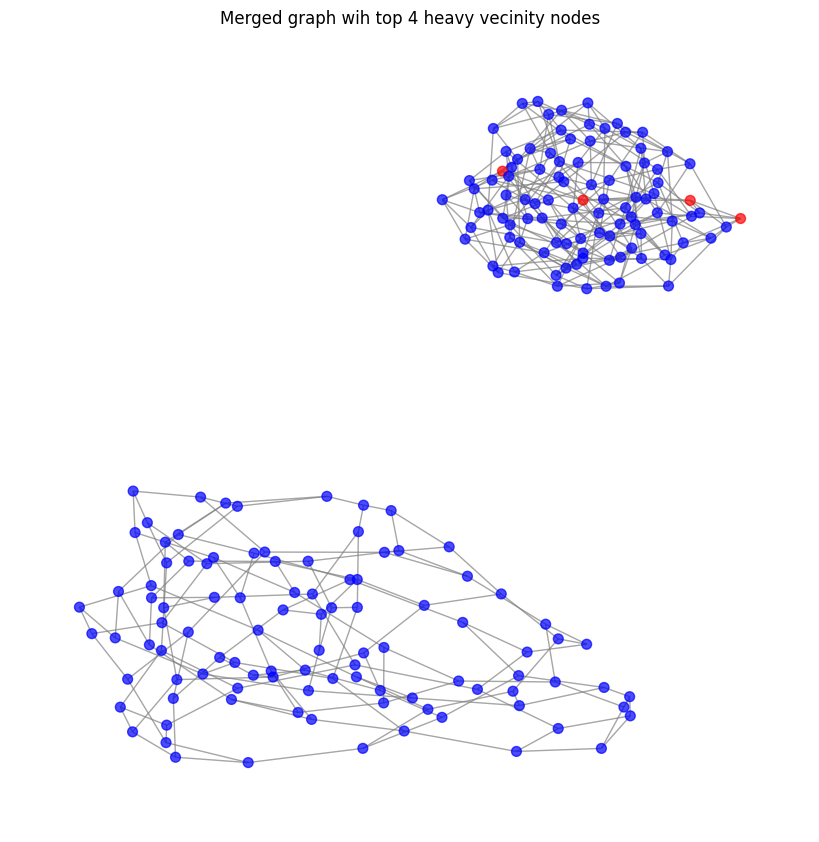

In [30]:
sorted_scores = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)
top_4_nodes = [node for node, _ in sorted_scores[:4]]

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(merged_graph)

node_colors = ['red' if node in top_4_nodes else 'blue' for node in merged_graph.nodes()]

nx.draw(merged_graph, pos, with_labels=False, node_color=node_colors, node_size=50, edge_color='gray', alpha=0.7)
plt.title("Merged graph wih top 4 heavy vecinity nodes")
plt.show()

Exercitiul 3

In [1]:
from scipy.io import loadmat
from torch_geometric.utils import from_scipy_sparse_matrix
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from sklearn.metrics import roc_auc_score
import torch

In [2]:
data = loadmat('ACM.mat')
attributes = data['Attributes']  
adjacency_matrix = data['Network'] 
labels = data['Label'] 

In [3]:
edge_index, edge_weight = from_scipy_sparse_matrix(adjacency_matrix)

X_tensor = torch.tensor(attributes.toarray(), dtype=torch.float)
y_tensor = torch.tensor(labels.flatten(), dtype=torch.long)
adjacency_matrix_tensor = torch.tensor(adjacency_matrix.toarray(), dtype=torch.float)

In [5]:
print(X_tensor.shape)
print(y_tensor.unique().shape[0])
print(y_tensor.shape)

torch.Size([16484, 8337])
2
torch.Size([16484])


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1) 
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2) 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) 
        x = F.relu(x) 
        x = self.conv2(x, edge_index) 
        x = F.relu(x) 
        return x  

In [7]:
class AttributeDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1=128, output_dim=None):
        super(AttributeDecoder, self).__init__()
        self.conv1 = GCNConv(latent_dim, hidden_dim1)  
        self.conv2 = GCNConv(hidden_dim1, output_dim) 

    def forward(self, z, edge_index):
        z = self.conv1(z, edge_index) 
        z = F.relu(z)  
        z = self.conv2(z, edge_index)  
        return z  

In [8]:
class StructureDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(StructureDecoder, self).__init__()
        self.conv = GCNConv(latent_dim, latent_dim)  

    def forward(self, z, edge_index):
        z = self.conv(z, edge_index)  
        z = F.relu(z)  
        adjacency_pred = torch.matmul(z, z.T)  
        return adjacency_pred 

In [9]:
class GraphAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1=128, hidden_dim2=64):
        super(GraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2)
        self.attribute_decoder = AttributeDecoder(hidden_dim2, hidden_dim1, input_dim)  
        self.structure_decoder = StructureDecoder(hidden_dim2) 

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)  
        
        reconstructed_attributes = self.attribute_decoder(z, edge_index)  
        reconstructed_adjacency = self.structure_decoder(z, edge_index) 
        
        return z, reconstructed_attributes, reconstructed_adjacency

In [10]:
def custom_loss_fct(X, X_hat, A, A_hat, alpha=0.8):
    attribute_loss = F.mse_loss(X, X_hat, reduction='sum')
    structure_loss = F.mse_loss(A, A_hat, reduction='sum') 
    
    loss = alpha * attribute_loss + (1 - alpha) * structure_loss
    
    return loss

In [11]:
def train_autoencoder(model, X_tensor, edge_index, adjacency_matrix, y_tensor, optimizer, epochs=50, alpha=0.8):
    optimizer = Adam(model.parameters(), lr=0.004)

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        _, X_hat, A_hat = model(X_tensor, edge_index)
        
        loss = custom_loss_fct(X_tensor, X_hat, adjacency_matrix, A_hat, alpha)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}, loss: {loss.item():.4f}")
            reconstruction_errors = torch.sum((X_tensor - X_hat) ** 2, dim=1).detach().cpu().numpy()
            roc_auc = roc_auc_score(y_tensor.cpu().numpy(), reconstruction_errors)
            print(f"Epoch {epoch + 1}: ROC AUC score: {roc_auc:.4f}")


In [12]:
input_dim = X_tensor.shape[1]  
model = GraphAutoencoder(input_dim)

device = torch.device("cpu")
model = model.to(device)
X_tensor = X_tensor.to(device)
edge_index = edge_index.to(device)
adjacency_matrix_tensor = adjacency_matrix_tensor.to(device)
y_tensor = y_tensor.to(device)

In [ ]:
#mi-a dat crash cand am incercat sa rulez
train_autoencoder(model, X_tensor, edge_index, adjacency_matrix_tensor, y_tensor)